In [1165]:
import warnings
warnings.filterwarnings("ignore")

In [1166]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.model_selection import GridSearchCV, PredefinedSplit
from scipy.stats import mode, pearsonr

## Question 1
Display the statistical values for each of the attributes, along with visualizations (e.g., histogram) of the distributions for each attribute. Are there any attributes that might require special treatment? If so, what special treatment might they require? 

### Pre-Processing Data


- retrieve labels from aggregate rock data 
    - retireve second column for labels


Rock Types Categories are 1 for Igneous, 2 for metamorphic, and 3 for sedimentary 

In [1167]:

labels = pd.read_excel("data/aggregateRockData.xlsx", header = None)[[1]][:480]
labels = labels.rename(columns={1: 'Rock_Types'})
labels.head()


,Rock_Types
0,1
1,1
2,1
3,1
4,1


- retrieve values from features
    - columns 3: 14

In [1168]:
column_headers = [ "Token_number", "Angular_fragments", "Rounded _fragments",
                   "Straight_stripes", "Curved_stripes", "Physical_layers", "Veins", "Oily/shimmery_texture",
                   "Splotchy_texture", "Single_translucent_crystal", "Multiple_cubic_crystals", "Sandy_texture"]

features = pd.read_csv('data/feature_presence540.txt', delim_whitespace=True, header=None).iloc[:480, 2:14]
features.columns = column_headers
features.head()


,Token_number,Angular_fragments,Rounded _fragments,Straight_stripes,Curved_stripes,Physical_layers,Veins,Oily/shimmery_texture,Splotchy_texture,Single_translucent_crystal,Multiple_cubic_crystals,Sandy_texture
0,1,0.20,0.15,0.00,0.0,0.00,0.05,0.0,0.30,0.0,0.00,0.10
1,2,0.65,0.15,0.00,0.0,0.05,0.00,0.0,0.10,0.0,0.05,0.05
2,3,0.60,0.00,0.00,0.0,0.05,0.00,0.0,0.35,0.0,0.00,0.05
3,4,0.10,0.85,0.00,0.0,0.05,0.00,0.0,0.10,0.0,0.00,0.10
4,5,0.35,0.80,0.00,0.0,0.00,0.00,0.0,0.10,0.0,0.00,0.05


Merge rock labels onto features and adjust data types

In [1169]:
DATA_DF = labels.merge(features, left_index=True, right_index=True)
DATA_DF

for col in DATA_DF.columns:
    # Convert to numeric if possible, otherwise keep the original type
    DATA_DF[col] = pd.to_numeric(DATA_DF[col], errors='ignore')
    
DATA_DF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 480 entries, 0 to 479
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Rock_Types                  480 non-null    int64  
 1   Token_number                480 non-null    int64  
 2   Angular_fragments           480 non-null    float64
 3   Rounded _fragments          480 non-null    float64
 4   Straight_stripes            480 non-null    float64
 5   Curved_stripes              480 non-null    float64
 6   Physical_layers             480 non-null    float64
 7   Veins                       480 non-null    float64
 8   Oily/shimmery_texture       480 non-null    float64
 9   Splotchy_texture            480 non-null    float64
 10  Single_translucent_crystal  480 non-null    float64
 11  Multiple_cubic_crystals     480 non-null    float64
 12  Sandy_texture               480 non-null    float64
dtypes: float64(11), int64(2)
memory usa

### Statistical Values

Basic Statistical Values

In [1170]:
DATA_DF.describe()

,Rock_Types,Token_number,Angular_fragments,Rounded _fragments,Straight_stripes,Curved_stripes,Physical_layers,Veins,Oily/shimmery_texture,Splotchy_texture,Single_translucent_crystal,Multiple_cubic_crystals,Sandy_texture
count,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000
mean,2.000000,8.500000,0.084479,0.080208,0.067729,0.042292,0.165146,0.052396,0.144479,0.141458,0.031667,0.025104,0.119854
std,0.817348,4.614582,0.193996,0.197648,0.194792,0.160970,0.216635,0.102676,0.265689,0.168222,0.135647,0.112153,0.173149
min,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,4.750000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2.000000,8.500000,0.000000,0.000000,0.000000,0.000000,0.100000,0.000000,0.000000,0.100000,0.000000,0.000000,0.050000
75%,3.000000,12.250000,0.050000,0.050000,0.000000,0.000000,0.212500,0.050000,0.100000,0.200000,0.000000,0.000000,0.150000
max,3.000000,16.000000,1.000000,1.000000,1.000000,1.000000,0.950000,0.900000,1.000000,0.950000,1.000000,1.000000,1.000000


Check Null and Missing Values

In [1171]:
DATA_DF.isnull().sum()

Rock_Types                    0
Token_number                  0
Angular_fragments             0
Rounded _fragments            0
Straight_stripes              0
Curved_stripes                0
Physical_layers               0
Veins                         0
Oily/shimmery_texture         0
Splotchy_texture              0
Single_translucent_crystal    0
Multiple_cubic_crystals       0
Sandy_texture                 0
dtype: int64

Plotting Histograms

In [1172]:
COLORMAP = plt.cm.inferno

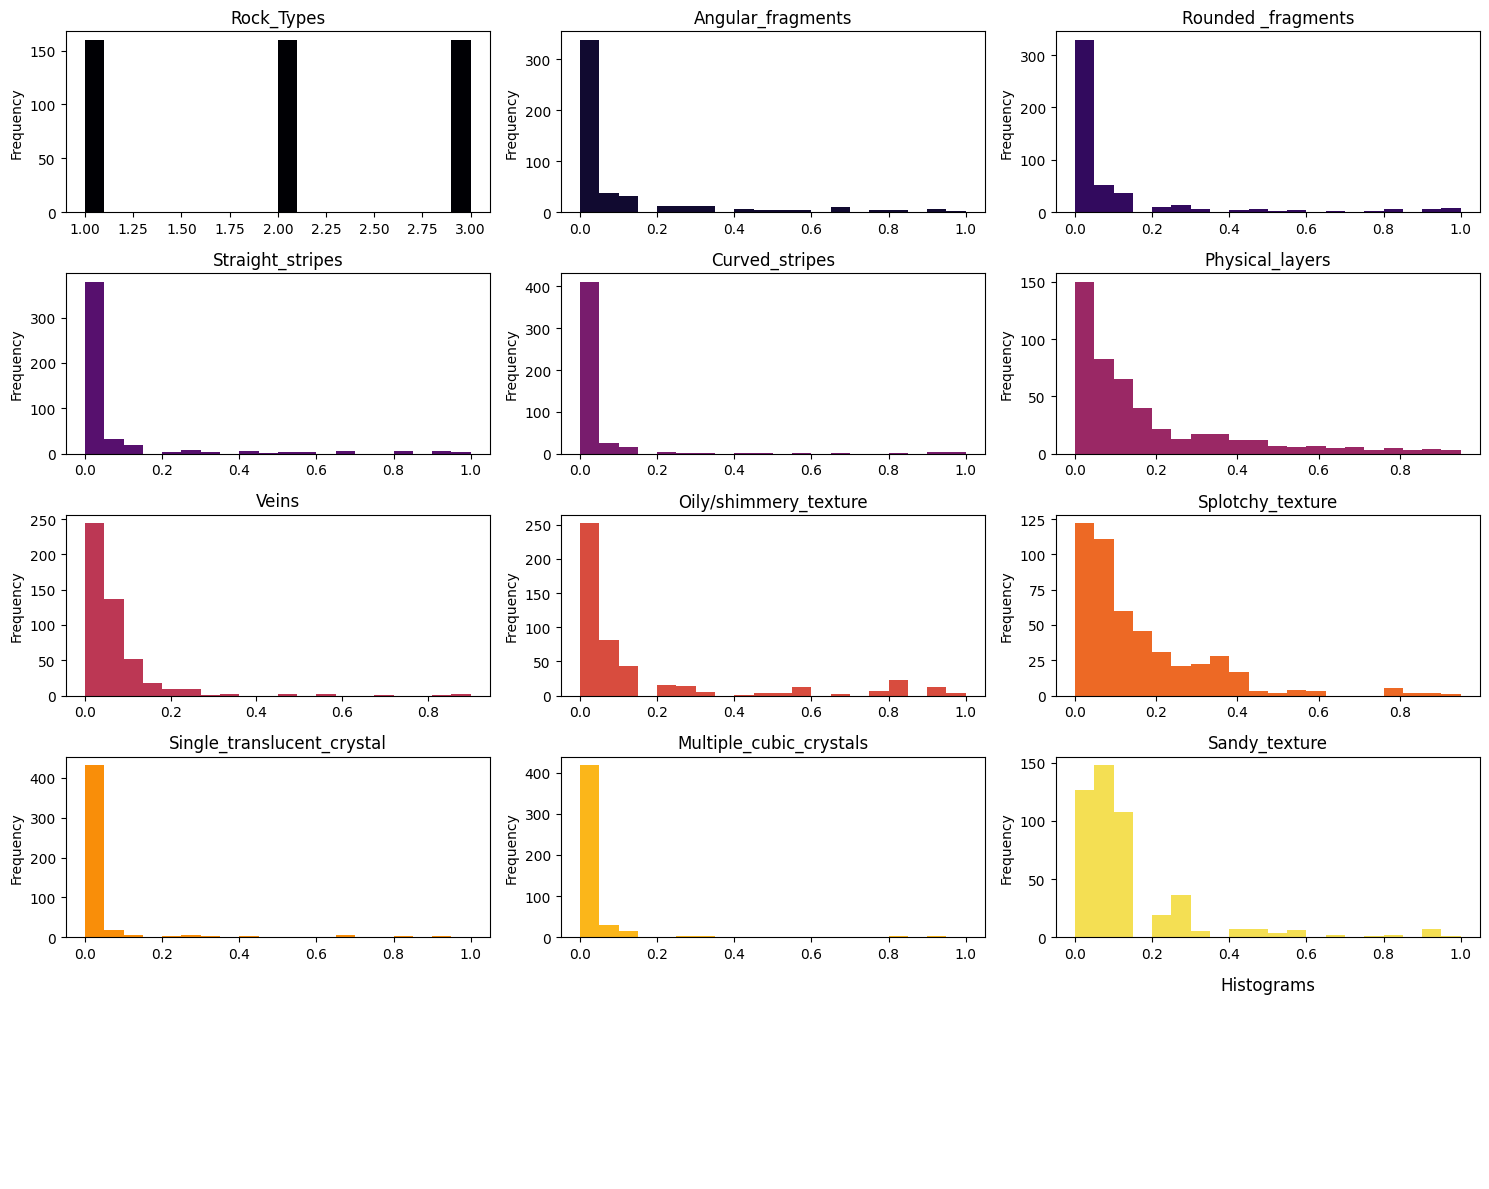

In [1173]:
filtered_data = DATA_DF.drop(columns=['Token_number'])

fig, axes = plt.subplots(5, 3, figsize=(15, 12)) 
axes = axes.flatten()

for i, (col, ax) in enumerate(zip(filtered_data.columns, axes)):
    color = COLORMAP(i / len(filtered_data.columns))  
    filtered_data[col].plot.hist(ax=ax, color=color, bins=20, grid=False)
    ax.set_title(col)

for j in range(i + 1, len(axes)):
    axes[j].axis("off")

plt.title('Histograms')
plt.tight_layout()
plt.show()

Plotting Box and Whiskers for features 

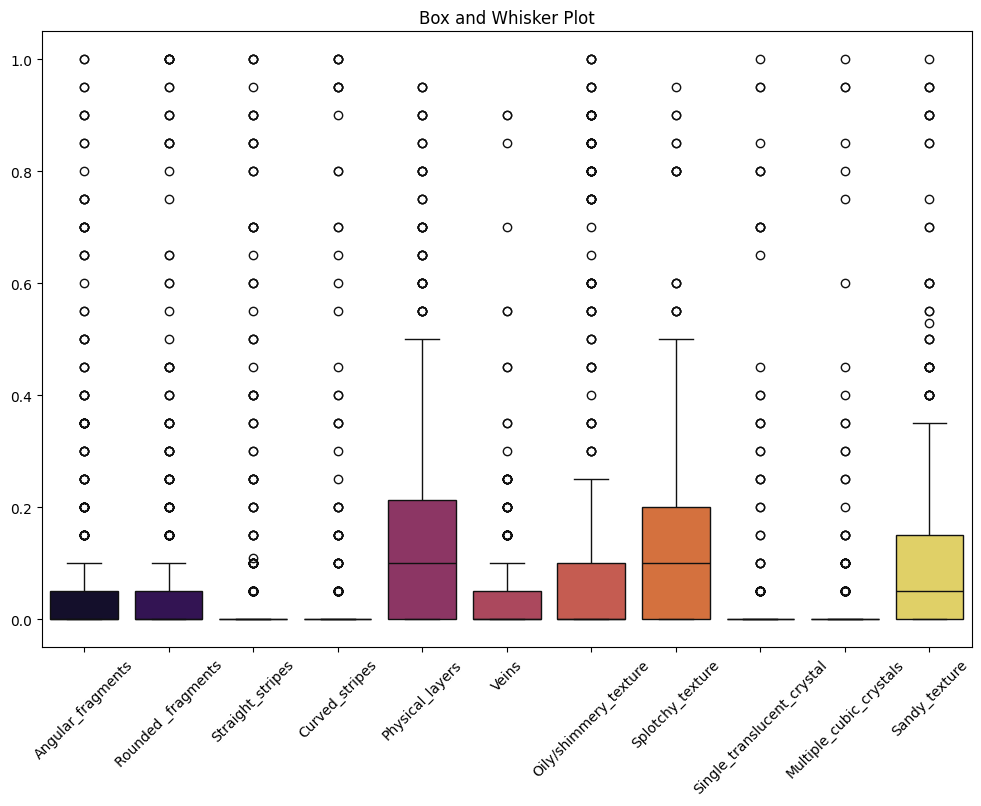

In [1174]:
filtered_data = DATA_DF.drop(columns=['Rock_Types', 'Token_number'])

palette = sns.color_palette("inferno", n_colors=len(filtered_data.columns))

plt.figure(figsize=(12, 8))
sns.boxplot(data=filtered_data, palette=palette)
plt.xticks(rotation=45)  
plt.title("Box and Whisker Plot")
plt.show()

### Observations

In the dataset, the target variable, "Rock Type," is evenly distributed among the three categories. All predictive features range from 0 to 1, exhibiting positively skewed distributions which may need to be scaled using Standard Scaler. Additionally, there are no null values, and all variables except the target are continuous so no label encoding is needed.

# Question 2
Analyze and discuss the relationships between the data attributes and between the data attributes and labels. This involves computing the Pearson Correlation Coefficient (PCC) and generating scatter plots.


In [1175]:

TARGET_VARIABLE = 'Rock_Types'
FEATURES = DATA_DF.columns.drop([TARGET_VARIABLE, 'Token_number'])

### Scatter Plots 

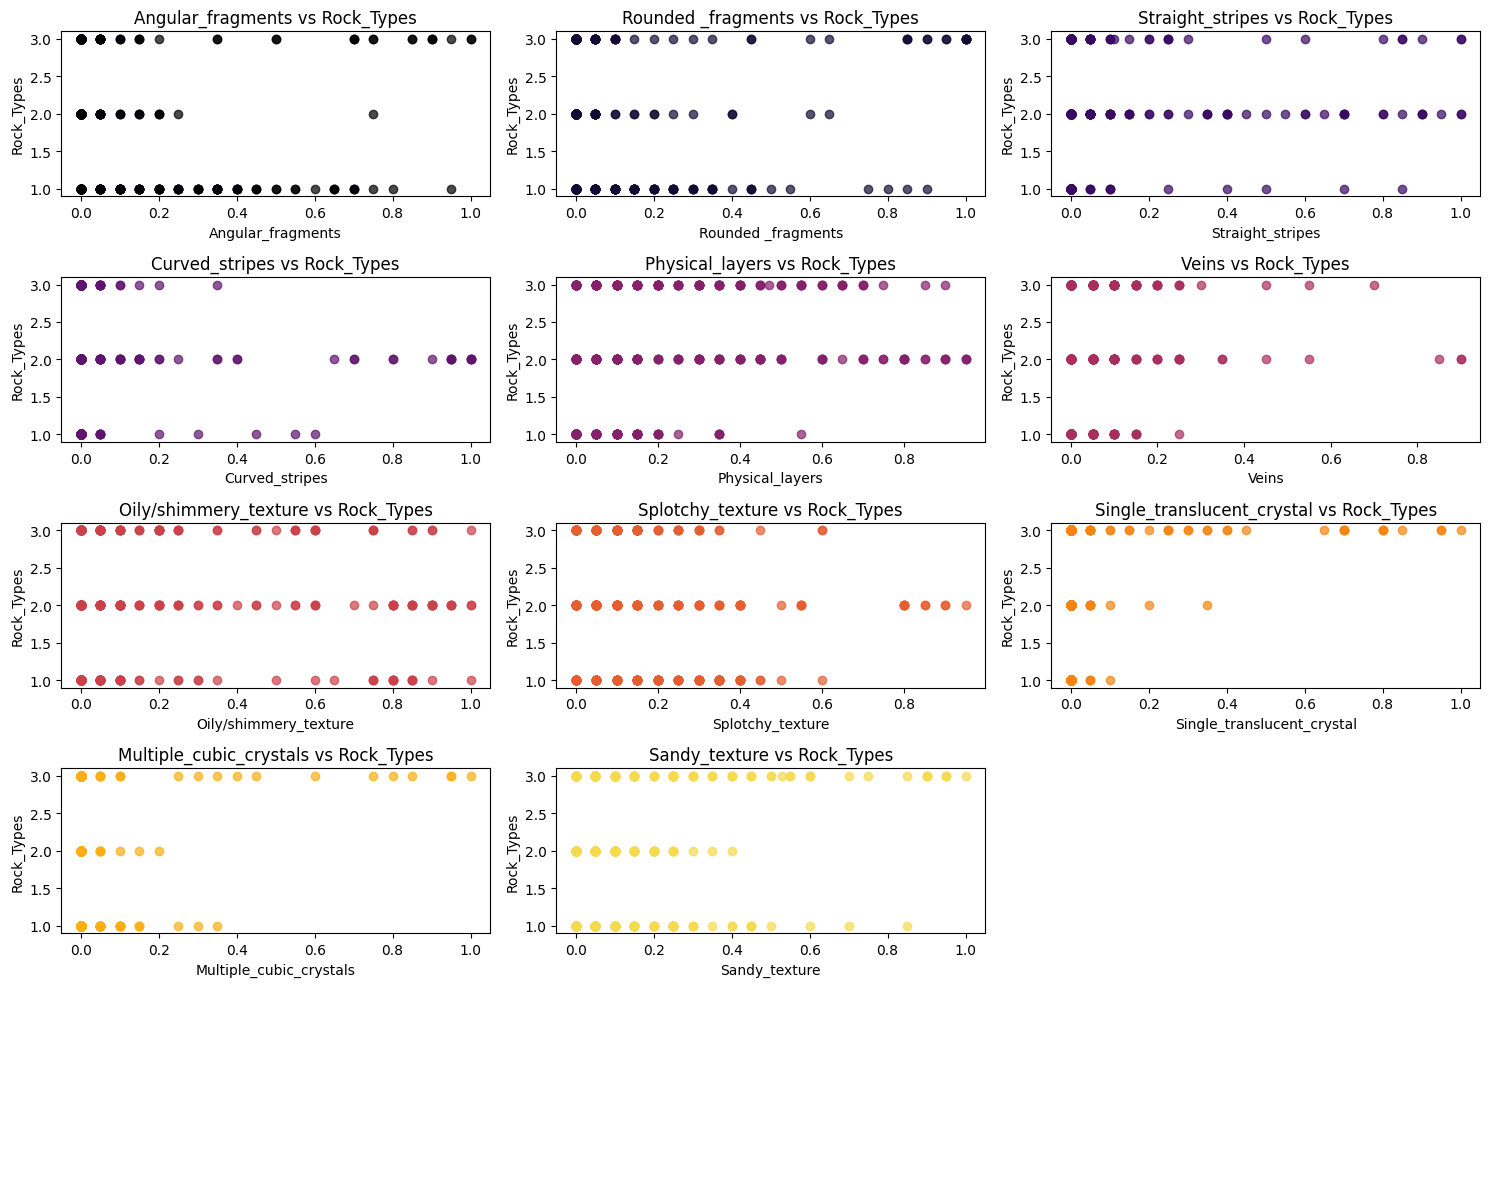

In [1176]:

fig, axes = plt.subplots(5, 3, figsize=(15,12))
axes = axes.flatten()

for i, feature in enumerate(FEATURES):
    ax = axes[i]
    color = COLORMAP(i / len(filtered_data.columns))  
    ax.scatter(DATA_DF[feature], DATA_DF[TARGET_VARIABLE], alpha=0.7, color=color)
    ax.set_xlabel(feature)
    ax.set_ylabel(TARGET_VARIABLE)
    ax.set_title(f"{feature} vs {TARGET_VARIABLE}")

# Hide any unused subplots if there are fewer features than subplots
for j in range(i + 1, len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()

### Pearson Correlation

Testing the pearson correlation of all feature values compared to the target column, sorting each value by the highest absolute error

In [1177]:

results = []
for i in FEATURES:
    stat, p_value = pearsonr(DATA_DF[i], DATA_DF[TARGET_VARIABLE])
    results.append({
        'Target': TARGET_VARIABLE,
        'Compared_Column': i,
        'Statistic': stat,
        'p_value': p_value

    })
            
stat = pd.DataFrame(results).sort_values(by='Statistic', key=abs, ascending=False)
print("Pearson Correlation of all features compared to target value Rock_Type")
stat

Pearson Correlation of all features compared to target value Rock_Type


,Target,Compared_Column,Statistic,p_value
4,Rock_Types,Physical_layers,0.266699,2.926048e-09
8,Rock_Types,Single_translucent_crystal,0.258910,8.608453e-09
7,Rock_Types,Splotchy_texture,-0.229273,3.818033e-07
5,Rock_Types,Veins,0.140553,2.024196e-03
10,Rock_Types,Sandy_texture,0.139845,2.133740e-03
0,Rock_Types,Angular_fragments,-0.122447,7.235725e-03
9,Rock_Types,Multiple_cubic_crystals,0.113872,1.254507e-02
2,Rock_Types,Straight_stripes,0.077495,8.989524e-02
3,Rock_Types,Curved_stripes,-0.017454,7.028771e-01
1,Rock_Types,Rounded _fragments,0.017446,7.030119e-01


### Correlation Matrix

<Axes: >

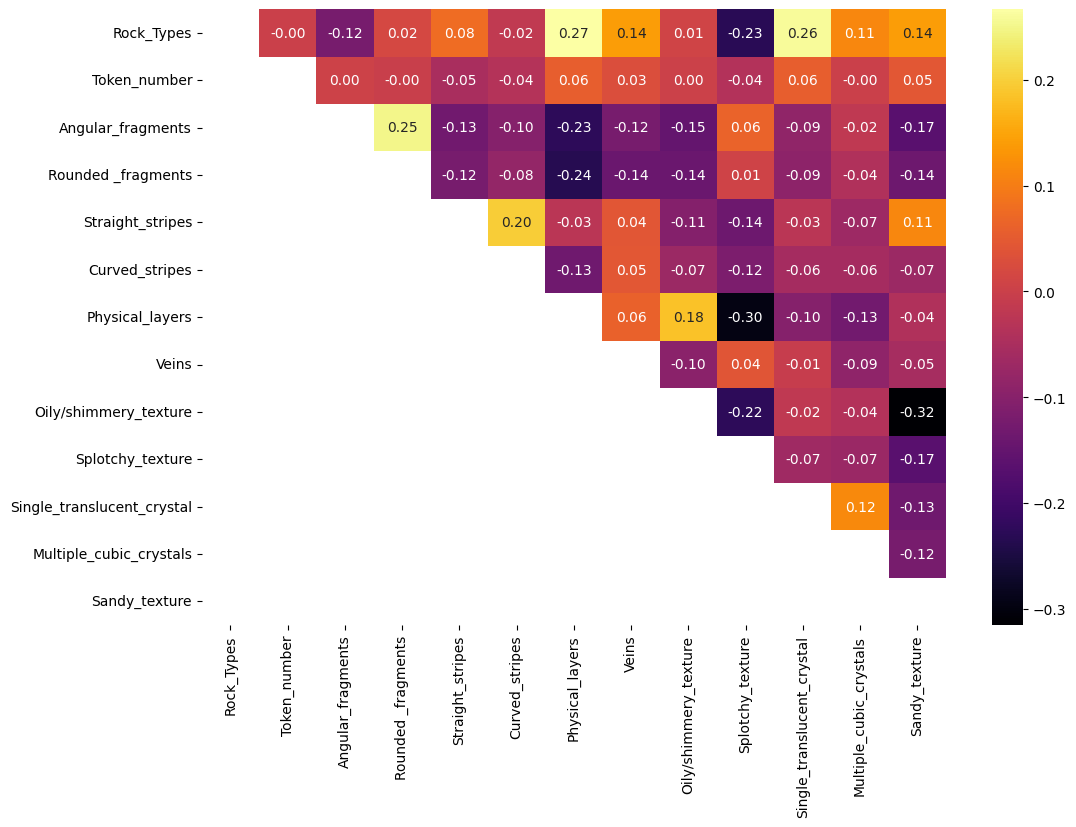

In [1178]:
# PCC matrix for attributes and labels
correlation_matrix = DATA_DF.corr()
mask = np.tril(np.ones_like(correlation_matrix, dtype=bool))
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, mask=mask, annot=True, fmt=".2f", cmap=COLORMAP)

### Observations

From scatter plots, Pearson correlation scores, and the correlation matrix, we observed that the features with the highest absolute correlation coefficients to our target variable are the physical layer attributes and single translucent crystal characteristics. These values are also validated by p values less than .05. 

# Question 3
For training data, use token numbers 1-10, for validation 11 to 13, and for testing 14 to 16 (each of the 30 rock subtypes has 16 token numbers).

### Splitting

Scale Data 

In [1179]:
scaler = StandardScaler()
DATA_DF[FEATURES] = scaler.fit_transform(DATA_DF[FEATURES])

Split data into Train-Test-Validate sets

In [1180]:
# Train Test Validate Split

train_tokens = [ x for x in range(1, 11)]
validate_tokens = [x for x in range(11, 14)]
test_tokens = [x for x in range(14, 17)]

train_data = DATA_DF[DATA_DF["Token_number"].isin(train_tokens)]
test_data = DATA_DF[DATA_DF["Token_number"].isin(test_tokens)]
validate_data = DATA_DF[DATA_DF["Token_number"].isin(validate_tokens)]

Splitting X and Y labels

In [1181]:
X_train, y_train = train_data[FEATURES], train_data[TARGET_VARIABLE]
X_test, y_test = test_data[FEATURES], test_data[TARGET_VARIABLE]
X_validate, y_validate = validate_data[FEATURES], validate_data[TARGET_VARIABLE]

Checking the amount of data in each split

In [1182]:
print("----------- Shape ------------")
print("training data: ", train_data.shape)
print("validate data: ", validate_data.shape)
print("test data: ", test_data.shape)

print("\n----------- Proportion ------------")
print(f"Training Data: {len(train_data)/ len(DATA_DF):.3f}%")
print(f"Validation Data: {len(validate_data)/ len(DATA_DF):.3f}%")
print(f"Testing Data: {len(test_data)/ len(DATA_DF):.3f}")

----------- Shape ------------
training data:  (300, 13)
validate data:  (90, 13)
test data:  (90, 13)

----------- Proportion ------------
Training Data: 0.625%
Validation Data: 0.188%
Testing Data: 0.188


### Check validity of splits

Ensure that each target class is represented in each split

In [1183]:

print("Target distribution in training data: ")
print(train_data[TARGET_VARIABLE].value_counts())

print("Target distribution in test data: ")
print(test_data[TARGET_VARIABLE].value_counts())

print("Target validate in training data: ")
print(validate_data[TARGET_VARIABLE].value_counts())

Target distribution in training data: 
Rock_Types
1    100
2    100
3    100
Name: count, dtype: int64
Target distribution in test data: 
Rock_Types
1    30
2    30
3    30
Name: count, dtype: int64
Target validate in training data: 
Rock_Types
1    30
2    30
3    30
Name: count, dtype: int64


Checking the box and whisker plots for each column for each split 

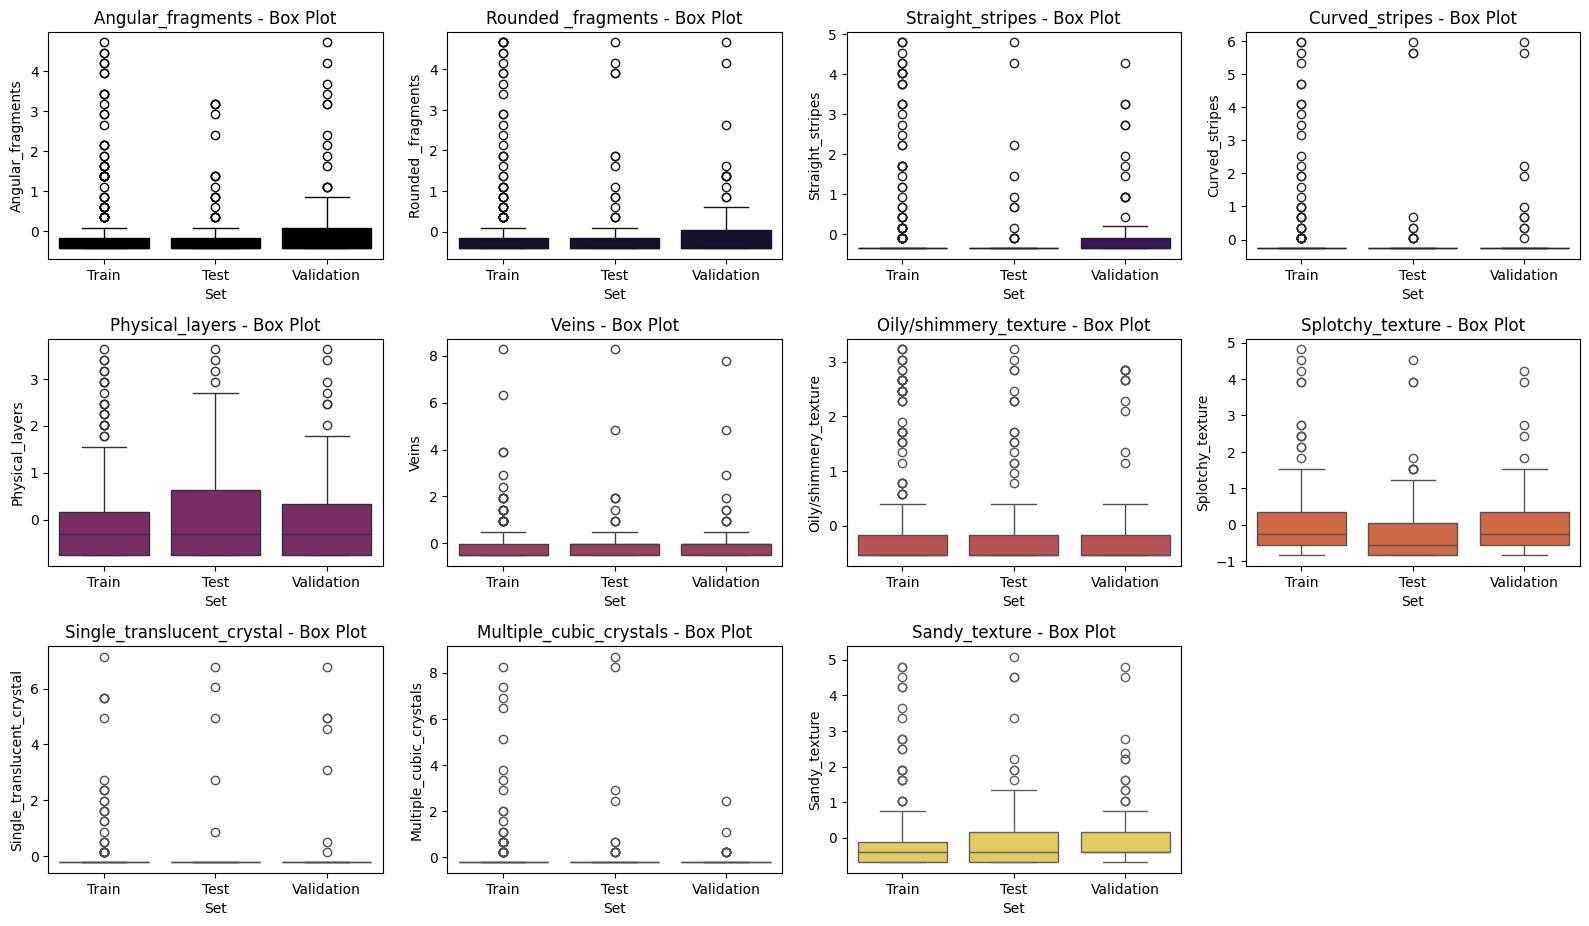

In [1184]:
train_data["Set"] = "Train"
test_data["Set"] = "Test"
validate_data["Set"] = "Validation"
combined_data = pd.concat([train_data, test_data, validate_data])

# Drop 'Token_number' column if it's not needed
combined_data = combined_data.drop(columns=["Token_number", "Rock_Types"])

plt.figure(figsize=(16, 12))
for i, column in enumerate(combined_data.columns[:-1]):  
    plt.subplot(4, 4, i + 1)
    color = COLORMAP(i / len(filtered_data.columns))  
    sns.boxplot(x="Set", y=column, data=combined_data, color=color)
    plt.title(f"{column} - Box Plot")

plt.tight_layout()
plt.show()

Check the mean and std of each column for each split

In [1185]:
summary_df = pd.DataFrame()

for column in DATA_DF.columns:
    if column != "Token_number":
        stats = {
            f"train_mean": train_data[column].mean(),
            f"train_std": train_data[column].std(),
            f"test_mean": test_data[column].mean(),
            f"test_std": test_data[column].std(),
            f"validate_mean": validate_data[column].mean(),
            f"validate_std": validate_data[column].std()
        }
        summary_df = pd.concat([summary_df, pd.DataFrame(stats, index=[column])])

summary_df.index.name = 'Column'
summary_df.reset_index(inplace=True)

summary_df

,Column,train_mean,train_std,test_mean,test_std,validate_mean,validate_std
0,Rock_Types,2.000000,0.817861,2.000000,0.821071,2.000000,0.821071
1,Angular_fragments,-0.025693,0.989579,-0.054647,0.866764,0.140291,1.151926
2,Rounded _fragments,0.003165,1.027976,-0.009496,1.024310,-0.001055,0.890938
3,Straight_stripes,0.031369,1.074117,-0.136791,0.806667,0.032226,0.918289
4,Curved_stripes,0.013733,0.986464,-0.021161,1.087949,-0.024616,0.968871
5,Physical_layers,-0.041492,0.952191,0.122550,1.112774,0.015756,1.042956
6,Veins,-0.033108,0.898548,0.052472,1.166730,0.057888,1.144407
7,Oily/shimmery_texture,0.004474,0.996713,0.008242,1.013430,-0.023156,1.013922
8,Splotchy_texture,0.019092,0.981341,-0.088021,1.070651,0.024382,1.000975
9,Single_translucent_crystal,-0.023369,0.878159,0.016399,1.158722,0.061498,1.205787


### Observations

When dividing the data into a 63/19/19 Train/Validation/Test split, we observed that following the provided indexing instructions yielded a fairly representative dataset. We validated this by comparing statistics like mean and standard deviation, as well as generating box-and-whisker plots for each column across all splits. The results were consistent across splits, with only minor variations due to expected noise.

# Question 4 
Train different classifiers and tweak the hyperparameters to improve performance (you can use the grid search if you want or manually try different values). Report training, validation and testing performance (classification accuracy, precision, recall and F1 score) and discuss the impact of the hyperparameters (use markdown cells in Jupyter Notebook to clearly indicate each solution):


Helpers for grid search

In [1186]:
X_pre_defined = np.concatenate((X_train, X_validate), axis=0)
y_pre_defined = np.concatenate((y_train, y_validate), axis=0)

split_index = [-1] * len(X_train) + [0] * len(X_validate)
predefined_split = PredefinedSplit(test_fold = split_index)


def evaluate_model(X_train, y_train, X_validate, y_validate, model):
    # Fit the model on the training data
    model.fit(X=X_train, y=y_train)
    
    # Training predictions and metrics
    y_train_pred = model.predict(X_train)
    print("---------------------- Training Metrics ----------------------")
    print("Accuracy: ", round(accuracy_score(y_train, y_train_pred), 3))
    print("Precision: ", precision_score(y_train, y_train_pred, average="macro").round(3))
    print("Recall: ", recall_score(y_train, y_train_pred, average="macro").round(3))
    print("F1 Score: ", f1_score(y_train, y_train_pred, average="macro").round(3))
    
    # Testing predictions and metrics
    y_validate_pred = model.predict(X_validate)
    print("---------------------- Testing Metrics ----------------------")
    print("Accuracy: ", round(accuracy_score(y_validate, y_validate_pred), 3))
    print("Precision: ", precision_score(y_validate, y_validate_pred, average="macro").round(3))
    print("Recall: ", recall_score(y_validate, y_validate_pred, average="macro").round(3))
    print("F1 Score: ", f1_score(y_validate, y_validate_pred, average="macro").round(3))


### Multinomial Logistic Regression (Softmax Regression)

In [1187]:
# Modelling

logreg = LogisticRegression(fit_intercept = True, multi_class = "multinomial", max_iter = 50)

# Evaluating on training data
evaluate_model(X_train, y_train, X_validate, y_validate, logreg)


---------------------- Training Metrics ----------------------
Accuracy:  0.67
Precision:  0.671
Recall:  0.67
F1 Score:  0.67
---------------------- Testing Metrics ----------------------
Accuracy:  0.756
Precision:  0.762
Recall:  0.756
F1 Score:  0.751


#### Hyper Parameter Tuning using grid search

In [1188]:

MODEL = LogisticRegression(fit_intercept=True)

# Define the base parameters and parameter grid
param_grid = {
    'solver': ['lbfgs', 'sag', 'saga', 'newton-cg'],
    'penalty': ['l1', 'l2', 'elsaticnet', 'none'],
    'C': [0.01, 0.1, 1, 10, 100],
    'max_iter': range(20,220,20)
}

grid_search = GridSearchCV(MODEL, param_grid, cv = predefined_split, scoring = 'accuracy', verbose = 1)

grid_search.fit(X_pre_defined, y_pre_defined)

# Get the best parameters and the best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Cross-Validated Accuracy:", best_score)

Fitting 1 folds for each of 800 candidates, totalling 800 fits
Best Parameters: {'C': 1, 'max_iter': 20, 'penalty': 'l1', 'solver': 'saga'}
Best Cross-Validated Accuracy: 0.7555555555555555


#### Hyperparameters selected for logistic regression:

Number of Iterations: 20

penalty = l1

C = 1

Solver = saga

#### Best Model Performance

In [1189]:
best_logreg = LogisticRegression(fit_intercept = True, multi_class = "multinomial", max_iter = 20, solver='saga', penalty='l1')

# Evaluating on training data
evaluate_model(X_train, y_train, X_validate, y_validate, best_logreg)


---------------------- Training Metrics ----------------------
Accuracy:  0.677
Precision:  0.678
Recall:  0.677
F1 Score:  0.677
---------------------- Testing Metrics ----------------------
Accuracy:  0.756
Precision:  0.762
Recall:  0.756
F1 Score:  0.751


### Support Vector Machines

In [1190]:
svm_model = SVC()
# Evaluating on training data
evaluate_model(X_train, y_train, X_validate, y_validate, svm_model)

---------------------- Training Metrics ----------------------
Accuracy:  0.737
Precision:  0.74
Recall:  0.737
F1 Score:  0.737
---------------------- Testing Metrics ----------------------
Accuracy:  0.767
Precision:  0.772
Recall:  0.767
F1 Score:  0.768


#### Hyper Parameter Tuning using grid search

In [1191]:

MODEL = SVC()

param_grid = {
    'gamma': [round(x * 0.01, 3) for x in range(0, 101, 10)],
    'kernel': ["linear", "poly", "rbf"],
    'C': [0.01, 0.1, 1, 10, 100],
    'degree': range(1,5)
}

grid_search = GridSearchCV(MODEL, param_grid, cv = predefined_split, scoring = 'accuracy', verbose = 1)
grid_search.fit(X_pre_defined, y_pre_defined)

print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validated Accuracy:", grid_search.best_score_)

Fitting 1 folds for each of 660 candidates, totalling 660 fits
Best Parameters: {'C': 1, 'degree': 1, 'gamma': 0.3, 'kernel': 'rbf'}
Best Cross-Validated Accuracy: 0.8


#### Selected Hyper Parameters for SVM:


Kernel: RBF

C: 1

Degree: 1

Gamma: 0.3

#### Best Model Performance

In [1192]:
best_svm_model = SVC(kernel='rbf', C=1, degree=1, gamma=.3)
evaluate_model(X_train, y_train, X_validate, y_validate, best_svm_model)

---------------------- Training Metrics ----------------------
Accuracy:  0.797
Precision:  0.798
Recall:  0.797
F1 Score:  0.797
---------------------- Testing Metrics ----------------------
Accuracy:  0.8
Precision:  0.8
Recall:  0.8
F1 Score:  0.799


### Random Forest classifier

In [1193]:
random_forest = RandomForestClassifier()
evaluate_model(X_train, y_train, X_validate, y_validate, random_forest)


---------------------- Training Metrics ----------------------
Accuracy:  1.0
Precision:  1.0
Recall:  1.0
F1 Score:  1.0
---------------------- Testing Metrics ----------------------
Accuracy:  0.778
Precision:  0.777
Recall:  0.778
F1 Score:  0.776


#### Hyper Parameter Tuning using grid search

In [1194]:
X_pre_defined = np.concatenate((X_train, X_validate), axis=0)
y_pre_defined = np.concatenate((y_train, y_validate), axis=0)

split_index = [-1] * len(X_train) + [0] * len(X_validate)
predefined_split = PredefinedSplit(test_fold = split_index)

param_grid = {
    'n_estimators' : [10, 20, 50, 100, 150, 200],
    'max_depth' : [2, 4, 8, 16, 32],
    'min_samples_split' : [2, 5, 10, 20],
    'min_samples_leaf' : [2, 4, 8, 16, 32, 64]
}

rf = RandomForestClassifier(random_state = 10)

grid_search = GridSearchCV(rf, param_grid, cv = predefined_split, scoring = 'accuracy', verbose = 1)

grid_search.fit(X_pre_defined, y_pre_defined)

print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validated Accuracy:", grid_search.best_score_)

Fitting 1 folds for each of 720 candidates, totalling 720 fits
Best Parameters: {'max_depth': 16, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 20}
Best Cross-Validated Accuracy: 0.8


#### Best Parameters for Random Forest:

Max Depth: 16

Min Samples Leaf: 2

Min Samples Split: 10

Number of Estimators: 20

#### Best Model Parameter

In [1195]:
best_random_forest = RandomForestClassifier(max_depth=16, min_samples_leaf=2, min_samples_split=10, n_estimators=20)
evaluate_model(X_train, y_train, X_validate, y_validate, best_random_forest)

---------------------- Training Metrics ----------------------
Accuracy:  0.86
Precision:  0.86
Recall:  0.86
F1 Score:  0.86
---------------------- Testing Metrics ----------------------
Accuracy:  0.711
Precision:  0.713
Recall:  0.711
F1 Score:  0.708


#### Feature Importance 

In [1196]:
feature_imps = list(best_random_forest.feature_importances_)
fi_df = pd.DataFrame(columns = ["Feature", "Importance"])

for itr in range(len(X_train.columns)):
    curr_row = [X_train.columns[itr], feature_imps[itr]]
    fi_df.loc[len(fi_df)] = curr_row

In [1197]:
fi_df.sort_values(by = ["Importance"], ascending = False)

,Feature,Importance
4,Physical_layers,0.135008
7,Splotchy_texture,0.126837
10,Sandy_texture,0.124768
0,Angular_fragments,0.098635
1,Rounded _fragments,0.096105
8,Single_translucent_crystal,0.085425
2,Straight_stripes,0.081344
6,Oily/shimmery_texture,0.078519
5,Veins,0.063762
3,Curved_stripes,0.058024


# Question 5
Combine your classifiers into an ensemble and try to outperform each individual classifier on the validation set. Once you have found a good one, try it on the test set. Describe and discuss your findings.

### Best Models

In [1198]:
# Best logistic regression model
best_logreg = LogisticRegression(fit_intercept = True, multi_class = "multinomial", max_iter = 20, solver='saga', penalty='l1')

# Best SVM model
best_svm_model = SVC(kernel='rbf', C=1, degree=1, gamma=.3, probability=True)

# Best Random Forest model
best_random_forest = RandomForestClassifier(max_depth=16, min_samples_leaf=2, min_samples_split=10, n_estimators=20)


### Hard Voting Ensemble

In [1199]:
models = [("lr", best_logreg), ("svm", best_svm_model), ("rf", best_random_forest)]

In [1200]:
vc_hard = VotingClassifier(estimators = models, voting = 'hard')
evaluate_model(X_train, y_train, X_validate, y_validate, vc_hard)

---------------------- Training Metrics ----------------------
Accuracy:  0.787
Precision:  0.788
Recall:  0.787
F1 Score:  0.787
---------------------- Testing Metrics ----------------------
Accuracy:  0.778
Precision:  0.779
Recall:  0.778
F1 Score:  0.775


### Soft Voting Ensemble

In [1201]:
vc_soft = VotingClassifier(estimators = models, voting = 'soft')
evaluate_model(X_train, y_train, X_validate, y_validate, vc_soft)

---------------------- Training Metrics ----------------------
Accuracy:  0.813
Precision:  0.815
Recall:  0.813
F1 Score:  0.814
---------------------- Testing Metrics ----------------------
Accuracy:  0.767
Precision:  0.764
Recall:  0.767
F1 Score:  0.763


### Comparisons of all models

In [1202]:
model_eval = [("logistic_regression", best_logreg), ("Support_vector_Machine", best_svm_model), ("random_forest", best_random_forest), ('Ensemble_soft_voting', vc_soft), ('Ensemble_hard_voting', vc_hard) ]
results = []
for name, model in model_eval:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_validate)
    results.append({
        'model': name,
        'Accuracy': accuracy_score(y_validate,y_pred),
        'Precision': precision_score(y_validate, y_pred, average = "macro"),
        'Recall': recall_score(y_validate, y_pred, average = "macro"),
        "F1 Score: ": f1_score(y_validate, y_pred, average = "macro"),

    })

    
result = pd.DataFrame(results).sort_values(by=['Accuracy'], ascending=False)
result

,model,Accuracy,Precision,Recall,F1 Score:
1,Support_vector_Machine,0.800000,0.799539,0.800000,0.799322
2,random_forest,0.788889,0.787542,0.788889,0.786884
3,Ensemble_soft_voting,0.777778,0.775365,0.777778,0.774206
4,Ensemble_hard_voting,0.777778,0.780240,0.777778,0.776133
0,logistic_regression,0.755556,0.762193,0.755556,0.751079


#### Observations

By looking at the metrics, the two models tied for the best score are the Support Vector Machine and the Ensemble with soft voting. This is suprising as I would imagine that an ensemble method should perform better in all cases. 

### Evaluating on the testing set

In [1203]:
vc_soft = VotingClassifier(estimators = models, voting = 'soft')
evaluate_model(X_train, y_train, X_test, y_test, vc_soft)

---------------------- Training Metrics ----------------------
Accuracy:  0.807
Precision:  0.809
Recall:  0.807
F1 Score:  0.807
---------------------- Testing Metrics ----------------------
Accuracy:  0.678
Precision:  0.682
Recall:  0.678
F1 Score:  0.678


In [1204]:
best_svm_model = SVC(kernel='rbf', C=1, degree=1, gamma=.3, probability=True)
evaluate_model(X_train, y_train, X_test, y_test, best_svm_model)

---------------------- Training Metrics ----------------------
Accuracy:  0.797
Precision:  0.798
Recall:  0.797
F1 Score:  0.797
---------------------- Testing Metrics ----------------------
Accuracy:  0.667
Precision:  0.668
Recall:  0.667
F1 Score:  0.667


#### Observations

Although the two models performed Identical on the validation test, the ensemble voting with soft voting outperforms the support vector machine in all accuracy measurements

# Question 6
Is your method better than a human?

In [1205]:
human_preds = pd.read_csv("data/trialData.csv")

In [1206]:
human_preds.shape

(88547, 12)

In [1207]:
human_preds.head()

,subid,block,trial,rocknumber,category,subtype,token,type,catresponse,recresponse,cat_correct,rec_correct
0,A1HUMXQ7SEXD8E,1,1,331,Sedimentary,Bituminous Coal,11,NonparentTraining,Metamorphic,NaN,0,NaN
1,A1HUMXQ7SEXD8E,1,2,398,Sedimentary,Dolomite,14,NonparentTraining,Igneous,NaN,0,NaN
2,A1HUMXQ7SEXD8E,1,3,19,Igneous,Basalt,3,NonparentTraining,Sedimentary,NaN,0,NaN
3,A1HUMXQ7SEXD8E,1,4,338,Sedimentary,Breccia,2,NonparentTraining,Metamorphic,NaN,0,NaN
4,A1HUMXQ7SEXD8E,1,5,60,Igneous,Gabbro,12,NonparentTraining,Sedimentary,NaN,0,NaN


In [1208]:
human_preds['block'].value_counts()

block
4    44274
3    14769
2    14755
1    14749
Name: count, dtype: int64

In [1209]:
human_preds = human_preds[human_preds["rocknumber"].isin(list(range(1, 481)))]
human_preds.shape

(83627, 12)

In [1210]:
train_human_preds = human_preds[human_preds["block"].isin([1, 2, 3])]
test_human_preds = human_preds[human_preds["block"].isin([4])]

In [1211]:
train_human_preds.shape

(44273, 12)

In [1212]:
test_human_preds.shape

(39354, 12)

### Mean and STD of Human Performance on each rocks

In [ ]:

print("---------------------- Train Metrics ----------------------")
rock_stats = train_human_preds.groupby("rocknumber")["cat_correct"].agg(["mean", "std"]).rename(columns={"mean": "human_accuracy", "std": "human_std"})
train_stats = rock_stats.reset_index()
train_stats

---------------------- Train Metrics ----------------------


,rocknumber,human_accuracy,human_std
0,1,0.764228,0.425346
1,9,0.642276,0.480307
2,11,0.430894,0.496211
3,12,0.772358,0.420165
4,14,0.726531,0.446652
...,...,...,...
175,466,0.321138,0.467866
176,469,0.552846,0.498213
177,473,0.422764,0.495006
178,474,0.386179,0.487865


In [1235]:
print("---------------------- Test Metrics ----------------------")
rock_stats = test_human_preds.groupby("rocknumber")["cat_correct"].agg(["mean", "std"]).rename(columns={"mean": "human_accuracy", "std": "human_std"})
test_stats = rock_stats.reset_index()
test_stats

---------------------- Test Metrics ----------------------


,rocknumber,human_accuracy,human_std
0,1,0.695122,0.463189
1,2,0.719512,0.452002
2,3,0.451220,0.500677
3,4,0.500000,0.503077
4,5,0.512195,0.502927
...,...,...,...
475,476,0.609756,0.490807
476,477,0.524390,0.502478
477,478,0.426829,0.497661
478,479,0.365854,0.484633


### Mean and STD of Human Performance of all rocks

In [1237]:
group_means = human_preds.groupby("rocknumber")["cat_correct"].mean()

overall_mean_of_all_rocks = group_means.mean()
overall_std_of_all_rocks = group_means.std()

print("Mean Accurracy on all rock :", overall_std_of_all_rocks)
print("Standard deviation of accuracy on all rocks:", overall_std_of_all_rocks)


Mean Accurracy on all rock : 0.20419130110744863
Standard deviation of accuracy on all rocks: 0.20419130110744863


In [1214]:
result

,model,Accuracy,Precision,Recall,F1 Score:
1,Support_vector_Machine,0.800000,0.799539,0.800000,0.799322
2,random_forest,0.788889,0.787542,0.788889,0.786884
3,Ensemble_soft_voting,0.777778,0.775365,0.777778,0.774206
4,Ensemble_hard_voting,0.777778,0.780240,0.777778,0.776133
0,logistic_regression,0.755556,0.762193,0.755556,0.751079


Recall the performance of each of our models, every single model significantly outperforms human performance

In [1216]:
human_preds

,subid,block,trial,rocknumber,category,subtype,token,type,catresponse,recresponse,cat_correct,rec_correct
0,A1HUMXQ7SEXD8E,1,1,331,Sedimentary,Bituminous Coal,11,NonparentTraining,Metamorphic,NaN,0,NaN
1,A1HUMXQ7SEXD8E,1,2,398,Sedimentary,Dolomite,14,NonparentTraining,Igneous,NaN,0,NaN
2,A1HUMXQ7SEXD8E,1,3,19,Igneous,Basalt,3,NonparentTraining,Sedimentary,NaN,0,NaN
3,A1HUMXQ7SEXD8E,1,4,338,Sedimentary,Breccia,2,NonparentTraining,Metamorphic,NaN,0,NaN
4,A1HUMXQ7SEXD8E,1,5,60,Igneous,Gabbro,12,NonparentTraining,Sedimentary,NaN,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
88541,A2FXYZE13N65FJ,4,1075,247,Metamorphic,Migmatite,7,NonparentTraining,Metamorphic,Yes,1,1.0
88542,A2FXYZE13N65FJ,4,1076,366,Sedimentary,Chert,14,StandardTransfer,Sedimentary,No,1,1.0
88543,A2FXYZE13N65FJ,4,1077,412,Sedimentary,Micrite,12,StandardTransfer,Sedimentary,No,1,1.0
88544,A2FXYZE13N65FJ,4,1078,476,Sedimentary,Shale,12,NonparentTraining,Metamorphic,Yes,0,1.0


In [1217]:
human_preds["rocknumber"].value_counts()

rocknumber
389    329
129    329
51     329
34     329
103    329
      ... 
373     82
111     82
94      81
191     81
6       81
Name: count, Length: 480, dtype: int64